In [1]:
#| export
verbose                       = None
check_memory_usage            = None
time_flag                     = None
window_size_percentage        = None
show_plots                    = None
reset_kernel                  = None
pre_configured_case           = None
case_id                       = None
frequency_factor              = None
frequency_factor_change_alias = None
check_parameters              = True
cuda_device                   = None
remove_lambdas_flag           = True

# Explained pre-trained module trial

## Instalation commands

In [2]:
#! git clone https://github.com/SalesforceAIResearch/uni2ts.git
#! cd uni2ts
#! pip install -e '.[notebook]' --no-warn-script-location
#! conda install anaconda::gluonts

## Import libraries

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [4]:
from dvats.all import *

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary 


Octave is ready <oct2py.core.Oct2Py object at 0x7fa74bbc0340>

















## Utilities

In [5]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

In [6]:
import importlib
def remove_lambdas(verbose = 0):
    path = "./uni2ts/src/uni2ts/distribution/mixture.py"
    if verbose > 0: print(f"remove_lambdas | read file {path}")
    # Read the file
    with open(path, 'r') as file:
        lines = file.readlines()
    # Check wether identity is defined or not
    identity_defined = any("def identity(" in line for line in lines)
    if verbose > 0: print(f"remove_lambdas | identity already defined? {identity_defined}")
    if not identity_defined: 
        if verbose > 0: print("remove_lambdas | Look for domain_map line")
        for i, line in enumerate(lines):
            if "@property" in line and "def domain_map" in lines[i+1]:                
                domain_map_property_index = i
                break
        if verbose > 0: print(f"remove_lambdas | Domain map in line {i}")
        # Insert identity function
        identity_code = """
    def identity(self, x): 
        return x

"""
        lines.insert(domain_map_property_index, identity_code)
        # Modify weights_logits line 
        inside_domain_map = False
        for i in range(domain_map_property_index, len(lines)):
            if "weights_logits" in lines[i]:
                # Reemplazar la línea para que use identity
                lines[i] = "            weights_logits = self.identity,\n"
                break
        # Write changes 
        with open(path, 'w') as file:
            file.writelines(lines)
        importlib.reload(uni2ts)
    else:
        if identity_defined:
            print("Identity already defined")    

### Ensure model is pickable

In [7]:
if remove_lambdas_flag: remove_lambdas(verbose = 2)

remove_lambdas | read file ./uni2ts/src/uni2ts/distribution/mixture.py
remove_lambdas | identity already defined? True
Identity already defined


## Load dataset artifact

### Check input parameters & set up default parameters

In [8]:
#| export
verbose                       = True  if verbose is None else verbose
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
window_size_percentage        = False if window_size_percentage is None else window_size_percentage
show_plots                    = True if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 7 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 1 if  cuda_device is None else cuda_device

In [9]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: True reset_kernel: False pre_configured_case: True case_id: 7 frequency_factor: 1 frequency_factor_change_alias True cuda_device 1


In [10]:
#| export
import dvats.config as cfg_
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

import uni2ts
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi
import pyarrow.feather as ft

In [11]:
#| export
wandb_api = wandb.Api()
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        verbose = verbose, 
        both = verbose > 0,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )
path = os.path.expanduser("~/work/nbs_pipeline/")
name="moirai_trial"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")
df_train = train_artifact.to_df()
df_train.shape

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/moirai_trial.ipynb.


GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%
wandb_group: None
analysis_mode: online
epochs: 100
freq is missing in original dict | 1s 
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest -> mi-santamaria/deepvats/toy:latest
r: 0.71
artifact_name is missing in original dict | toy 
time_col is missing in original dict | None 
valid_size: 0.2
csv_config is missing in original dict | {} 
batch_size: 512 -> 32
stride: 900 -> 1
mask_future: False
valid_artifact: None
norm_by_sample: False
norm_use_single_batch: False
mvp_ws: (15, 100) -> [10, 30]
data_cols is missing in original dict | [] 
data_fpath is missing in original dict | ~/data/toy.csv 
use_wandb: True
w: 100 -> 30
mask_stateful: True
mask_sync: False
alias: PulsusParadoxus-SP02 -> toy
norm_use_by_single_batch is missing in original dict | (False,) 
runname: moirai_trial
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: 

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: [False]
---> W&B Train Artifact


wandb:   1 of 1 files downloaded.  


(550, 3)

In [12]:
display(df_train.head())

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


### Sliding windows

In [13]:
#| export
if verbose > 0: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if verbose > 0: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if verbose > 0: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

---> Sliding window |  30  |  1
 Sliding window |  30  |  1 ---> | df_train ~  (550, 3)
 sw_df_train |  30  |  1 --->


In [14]:
#| hide
if verbose > 0: 
    print(X_train.shape)

(521, 3, 30)


len(X):  521
--> Split 1


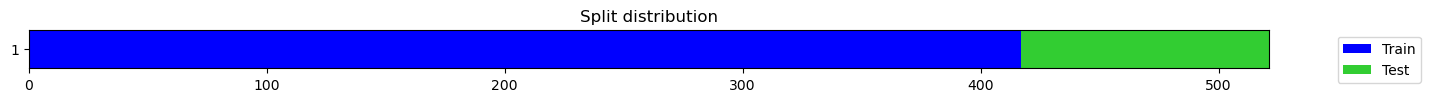

Split --> 417


In [15]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if verbose > 0: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if verbose > 0: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if verbose > 0: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if verbose > 0: 
    print("Split -->", len(splits[0]))


In [16]:
#| hide
if verbose > 0: 
    print(X.shape)
    display(splits)

(521, 3, 30)


((#417) [0,1,2,3,4,5,6,7,8,9...],
 (#104) [417,418,419,420,421,422,423,424,425,426...])

## Load & get embeddings from moirai module

In [17]:
def create_variate_id(
    batch_size, 
    seq_len, 
    num_variates
):
    # Crear un tensor de variate_id con tamaño (batch_size, seq_len, num_variates)
    variate_id = torch.arange(num_variates).unsqueeze(0).unsqueeze(0).repeat(batch_size, seq_len, 1)
    return variate_id

In [18]:
batch_size, num_variates, seq_len = X.shape

Aquí tendremos que seleccionar cualquiera de los modelos preentrenados en Moirai

In [19]:
model_size = 'large'
#model_size = 'small'

Nuestro X tiene tamaño 
num_ventanas x num_variables x tamaño_ventana

El target que recibe Moirai tiene tamaño 
num_ventanas x tamaño_ventana x num_variables

Permutamos para ajustar la entrada correctamente

In [20]:
# Create target ~ ( batch , seq_length , max_patch )
target = torch.randn(batch_size, seq_len, num_variates)
target.shape

torch.Size([521, 30, 3])

Como todos los valores son observados, hacemos que el observed mask esté a 1
Como el tamaño es el mismo que el del target, usamos torch.ones

In [21]:
X.shape

(521, 3, 30)

In [22]:
num_windows, num_variates, window_len = X.shape

---> Me hubiera gustado coger patch_size 8  para que tuviera sentido para toy que la ventana tiene tamaño 30, pero parece ser que el modelo está pre-entrenado con tamaño 128 y eso nos da problemas. Igual podemos paddear a 0 también de manera individual cada token (a modo de ñapa)

In [23]:
batch_size = num_windows
seq_len = window_len * num_variates
#patch_size = 8 
patch_size = 128
max_patch = patch_size

In [24]:
def split_and_pad(X, patch_size):
    # X tiene forma (bs, n variables, longitud)
    bs, n_vars, length = X.shape
    
    # Calculamos el número de patches
    n_patches = int(np.ceil(length / patch_size))
    
    # Creamos un array con ceros que tenga el tamaño del nuevo array dividido en patches
    padded_length = n_patches * patch_size
    X_padded = np.zeros((bs, n_vars, padded_length))
    
    # Rellenamos X_padded con los valores originales de X
    X_padded[:, :, :length] = X
    
    # Ahora dividimos X_padded en bloques de tamaño patch_size
    X_patches = X_padded.reshape(bs, n_vars, n_patches, patch_size)
    
    X_flat = X_patches.transpose(0, 2, 1, 3).reshape(bs, n_patches * n_vars, patch_size)

    # Transformamos a un tensor de PyTorch
    X_patches_torch = torch.tensor(X_flat)
    
    return X_patches_torch

In [25]:
n_patches = np.ceil(window_len/patch_size)
n_patches

1.0

In [26]:
np.ceil(window_len/patch_size)*num_variates

3.0

In [27]:
target = split_and_pad(X, patch_size)

In [28]:
batch_size, seq_len, max_patch = target.shape

In [29]:
observed_mask = torch.zeros_like(target)

In [30]:
def get_sample_id(X_patches_torch):
    batch_size, seq_len, _ = X_patches_torch.shape
    # Generamos un tensor que comienza en 0 y va incrementando de 1 en 1 hasta seq_len * batch_size - 1
    return torch.arange(batch_size * seq_len).view(batch_size, seq_len)


In [31]:
sample_id = get_sample_id(target)
print(sample_id.shape)
print(sample_id)

torch.Size([521, 3])
tensor([[   0,    1,    2],
        [   3,    4,    5],
        [   6,    7,    8],
        ...,
        [1554, 1555, 1556],
        [1557, 1558, 1559],
        [1560, 1561, 1562]])


In [32]:
def get_variate_id(batch_size, seq_len, n_vars, patches_per_var):
    patches_per_var = int(patches_per_var)
    # Creamos un tensor que repite cada ID de variable patches_per_var veces
    var_ids = torch.arange(n_vars).repeat_interleave(patches_per_var)
    # Repetimos este patrón para cada muestra en el batch
    return var_ids.unsqueeze(0).repeat(batch_size, 1)

In [33]:
print(f"batch_size {batch_size}, \n seq_len {seq_len}, \n n_vars {num_variates}, \n  patches_per_var {n_patches}")

batch_size 521, 
 seq_len 3, 
 n_vars 3, 
  patches_per_var 1.0


In [34]:
variate_id = get_variate_id(
    batch_size = batch_size, 
    seq_len = seq_len, 
    n_vars = num_variates, 
    patches_per_var = n_patches
)
print(variate_id.shape)
print(variate_id)

torch.Size([521, 3])
tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        ...,
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]])


In [35]:
def get_time_id(batch_size, seq_len, patches_per_var):
    patches_per_var = int (patches_per_var)
    # Creamos un tensor que repite una secuencia de 0 a patches_per_var-1
    time_ids = torch.arange(patches_per_var).repeat(seq_len // patches_per_var + 1)[:seq_len]
    # Repetimos este patrón para cada muestra en el batch
    return time_ids.unsqueeze(0).repeat(batch_size, 1)

In [36]:
time_id = get_time_id(batch_size, seq_len, n_patches)
print(time_id.shape)
print(time_id)

torch.Size([521, 3])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [37]:
# Get pre-trained module
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{model_size}")

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

In [38]:
prediction_mask = torch.zeros((batch_size, seq_len), dtype=torch.bool)

In [39]:
patch_size_tensor = torch.zeros((batch_size, patch_size))+patch_size
patch_size_tensor.shape

torch.Size([521, 128])

In [40]:
? module.forward

Signature:
 module.forward(
    target: jaxtyping.Float[Tensor, '*batch seq_len max_patch'],
    observed_mask: jaxtyping.Bool[Tensor, '*batch seq_len max_patch'],
    sample_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    time_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    variate_id: jaxtyping.Int[Tensor, '*batch seq_len'],
    prediction_mask: jaxtyping.Bool[Tensor, '*batch seq_len'],
    patch_size: jaxtyping.Int[Tensor, '*batch seq_len'],
) -> torch.distributions.distribution.Distribution
Docstring:
Defines the forward pass of MoiraiModule.
This method expects processed inputs.

1. Apply scaling to observations
2. Project from observations to representations
3. Replace prediction window with learnable mask
4. Apply transformer layers
5. Project from representations to distribution parameters
6. Return distribution object

:param target: input data
:param observed_mask: binary mask for missing values, 1 if observed, 0 otherwise
:param sample_id: indices indicating the sample ind

In [41]:
print(f"target ~ {target.shape}")
print(f"observed_mask ~ {observed_mask.shape}")
print(f"sample_id ~ {sample_id.shape}")
print(f"time_id ~ {time_id.shape}")
print(f"variate_id ~ {variate_id.shape}")
print(f"prediction_mask ~ {prediction_mask.shape}")
print(f"patch_size_tensor ~ {patch_size_tensor.shape}")

target ~ torch.Size([521, 3, 128])
observed_mask ~ torch.Size([521, 3, 128])
sample_id ~ torch.Size([521, 3])
time_id ~ torch.Size([521, 3])
variate_id ~ torch.Size([521, 3])
prediction_mask ~ torch.Size([521, 3])
patch_size_tensor ~ torch.Size([521, 128])


---> Aquí cuidado porque he tenido que poner parche en 


File ~/work/nbs_pipeline/uni2ts/src/uni2ts/module/ts_embed.py:100, in MultiInSizeLinear.forward(self, x, in_feat_size)
     
     96     weight = self.weight[idx] * self.mask[idx]
     
     97     bias = self.bias[idx] if self.bias is not None else 0
     
     98     out = out + (
     99         torch.eq(in_feat_size, feat_size).unsqueeze(-1)
     
--> 100         * (einsum(weight, x, "out inp, ... inp -> ... out") + bias)
    
    101     )
    
    102 return out

para convertir todo a double

Modificado a

def forward(
        
        self,
        
        x: Float[torch.Tensor, "*batch max_feat"],
    
        in_feat_size: Int[torch.Tensor, "*batch"],
    
    ) -> Float[torch.Tensor, "*batch out_feat"]:
        
        out = 0

        for idx, feat_size in enumerate(self.in_features_ls):
            
            weight = self.weight[idx].float() * self.mask[idx].float()  # Convertimos a Float
            
            bias = self.bias[idx].float() if self.bias is not None else 0  # Convertimos a Float
            
            x = x.float()  # Asegúrate de que x también esté en Float
            
            out = out + (
                
                torch.eq(in_feat_size, feat_size).unsqueeze(-1)
                
                * (torch.einsum("out inp, ... inp -> ... out", weight, x) + bias)
        
            )

        return out


In [42]:
target.shape

torch.Size([521, 3, 128])

In [45]:
? module.save_hyperparameters

Object ` module.save_hyperparameters` not found.


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


In [43]:
res = module(
    target = target.float(),
    observed_mask = observed_mask.float(),
    sample_id = sample_id,
    time_id = time_id,
    variate_id = variate_id,
    prediction_mask = prediction_mask,
    patch_size = patch_size_tensor.double()
)

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
print(patch_size_tensor.shape)